# Clustering

In this lab, we will take a brief look at clustering, which is an application of unsupervised learning. We will explore the [data from the Federal Communications Commission (FCC)'s Measuring Broadband America (MBA) project](https://www.fcc.gov/oet/mba/raw-data-releases), which measures ``speed'' from different Internet Service Providers (ISPs) across the United States.

In [1]:
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
from sklearn.cluster import KMeans, MiniBatchKMeans

## Loading the Dataset

Let's first have a quick look at the data.

In [2]:
df = pd.read_csv('../data/curr_httpgetmt.csv.gz', compression='gzip', error_bad_lines=False)
df = df.loc[:,['unit_id','dtime','target','address','bytes_sec']]
df.head(10)

,unit_id,dtime,target,address,bytes_sec
0,386,2020-03-01 00:35:07,samknows1.nyc2.level3.net,4.71.185.62,18693531
1,386,2020-03-01 00:36:34,sp2-vm-newyork-us.samknows.com,151.139.31.8,22842816
2,386,2020-03-01 00:38:37,newyorkfcc.west.verizon.net,206.124.86.197,22037046
3,386,2020-03-01 01:35:10,samknows1.nyc2.level3.net,4.71.185.62,20522792
4,386,2020-03-01 01:36:36,sp2-vm-newyork-us.samknows.com,151.139.31.8,22211256
5,386,2020-03-01 02:36:13,newyorkfcc.west.verizon.net,206.124.86.197,22419987
6,386,2020-03-01 02:39:52,samknows1.nyc2.level3.net,4.71.185.62,21314905
7,386,2020-03-01 02:41:14,sp2-vm-newyork-us.samknows.com,151.139.31.8,21628859
8,386,2020-03-01 03:34:56,samknows1.nyc2.level3.net,4.71.185.62,21955952
9,386,2020-03-01 03:36:48,sp2-vm-newyork-us.samknows.com,151.139.31.8,22729894


We can see that there are 5284 unique devices performing measurements in March 2020, and that there were about 3 million unique measurements

In [3]:
df['unit_id'].nunique()

5284

In [4]:
df.shape

(3046851, 5)

Let's rank the devices based on their maximum speedtest for the month and drop the devices that had zero throughput measurements.

In [5]:
max_df = df.groupby(['unit_id']).max()
max_df = max_df.sort_values(by=['bytes_sec'])
max_df = max_df.replace(0, np.nan).dropna().reset_index()
max_df.drop(columns=['dtime','address'],inplace=True)
max_df.reset_index()
max_df['rank'] = max_df.index
max_df

,unit_id,target,bytes_sec,rank
0,10695,sp2-vm-newyork-us.samknows.com,3761.0,0
1,12719,whplny-1-on.cv.net,34357.0,1
2,3941957,sp1-vm-dallas-us.samknows.com,60752.0,2
3,3880565,sp2-vm-newyork-us.samknows.com,62865.0,3
4,3941945,sp2-vm-newyork-us.samknows.com,64802.0,4
...,...,...,...,...
5276,25619237,sp1-vm-seattle-us.samknows.com,117677428.0,5276
5277,998117,sp2-vm-chicago-us.samknows.com,117680831.0,5277
5278,3994609,sp2-vm-chicago-us.samknows.com,117682541.0,5278
5279,23665993,whplny-1-on.cv.net,117683494.0,5279


We can look at the devices, ranked by their maximum speed measurement for the month.

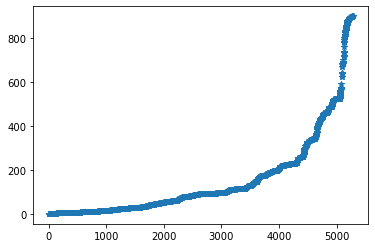

In [6]:
plt.plot(max_df.index,(max_df['bytes_sec']*8)/(1024*1024),'*')

## K Means Clustering

Let's merge the rank of the units back into the original dataframe and then cluster based on the max speed test for the month.

In [7]:
s = pd.merge(df,max_df, on=['unit_id']).sort_values(by='rank').reset_index()

In [8]:
cluster = KMeans(n_clusters=3)
cluster.fit(s['bytes_sec_y'].values.reshape(-1,1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Finally, we can visualize all measurements for the devices, with the points colored according to the group assigned to each device based on its maximum speed test.

In [ ]:
import matplotlib.cm as cm

colormap = cm.rainbow(np.linspace(0, 1, len(cluster.cluster_centers_)))
plt.scatter(s['rank']/len(max_df),(s['bytes_sec_x']*8)/(1024*1024),c=colormap[cluster.labels_])